- BatchBernoulliSampler抽样器
    - 特别注意不会自动停止 因为是有放回的 `batches_per_epoch`
- 封装多个流程性函数，调用mps
    - 注意tensor.cpu()

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable, grad
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
import tqdm
torch.manual_seed(0)

/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Library/Python/3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [44]:
import torch
from torch.utils.data import Dataset, DataLoader, Sampler
import numpy as np

class BatchBernoulliSampler(Sampler):

    """
        实现有放回的伯努利抽样
    """

    def __init__(self, data_source, batch_size = 10, p=0.7):
        self.data_source = data_source
        self.batch_size = batch_size
        self.p = p  

    def __iter__(self):
        n = len(self.data_source)
        
        while True:
            # 首先随机选择batch_size个样本（有放回）
            batch_indices = torch.randint(0, n, (self.batch_size,)).tolist()
            # 对这些样本进行伯努利抽样
            final_batch = [idx for idx in batch_indices if torch.rand(1).item() < self.p]
            if len(final_batch) > 0:
                yield final_batch

    def __len__(self):
        return int(len(self.data_source) * self.p / self.batch_size)

In [47]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import Sampler
# Load CIFAR10 data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

batch_size = 16
sampler = BatchBernoulliSampler(trainset, batch_size=batch_size, p=0.8)
trainloader = DataLoader(trainset, batch_sampler=sampler, num_workers=2)
gradloader = torch.utils.data.DataLoader(trainset, batch_size=4,
											shuffle=False, num_workers=2) #to get the gradient for each epoch

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
										download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
										shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
			'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [46]:
class CovNet(nn.Module):
	def __init__(self):
		super(CovNet, self).__init__()
		self.conv1 = nn.Conv2d(3, 6, 5)
		self.pool = nn.MaxPool2d(2, 2)
		self.conv2 = nn.Conv2d(6, 16, 5)
		self.fc1 = nn.Linear(16 * 5 * 5, 120)
		self.fc2 = nn.Linear(120, 84)
		self.fc3 = nn.Linear(84, 10)

	def forward(self, x):
		x = self.pool(F.relu(self.conv1(x)))
		x = self.pool(F.relu(self.conv2(x)))
		x = x.view(-1, 16 * 5 * 5)
		x = F.relu(self.fc1(x))
		x = F.relu(self.fc2(x))
		x = self.fc3(x)
		return x

In [48]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import time
import numpy as np
from tqdm import tqdm

def train_model(net, n_epoch, trainloader, gradloader, learning_rate, device, batches_per_epoch):
    criterion = nn.CrossEntropyLoss()
    net.to(device)  

    grad_norm_epoch = [0 for _ in range(n_epoch)]
    full_loss_epoch = [0 for _ in range(n_epoch)]

    start = time.time()

    for epoch in range(n_epoch):
        net.zero_grad()
        
        running_loss = 0.0
        batch_count = 0
        for data in tqdm(gradloader, desc=f"Epoch {epoch+1}/{n_epoch} (Full Grad)", total=batches_per_epoch):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss_grad = criterion(outputs, labels)
            loss_grad.backward()
            full_loss_epoch[epoch] += loss_grad.item()
            batch_count += 1
            if batch_count >= batches_per_epoch:
                break

        grad_norm_epoch[epoch] = np.sqrt(sum((para.grad.data.norm(2)**2).cpu().item() for para in net.parameters()) / batches_per_epoch)
        full_loss_epoch[epoch] /= batches_per_epoch

        batch_count = 0
        for data in tqdm(trainloader, desc=f"Epoch {epoch+1}/{n_epoch} (Training)", total=batches_per_epoch):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            net.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            for f in net.parameters():
                f.data.sub_(f.grad.data * learning_rate)
            running_loss += loss.item()
            batch_count += 1
            if batch_count >= batches_per_epoch:
                break

        # Print running loss every epoch
        print(f'Epoch [{epoch + 1}/{n_epoch}], Loss: {running_loss / batches_per_epoch:.3f}')

    end = time.time()
    print('Time elapsed: ', end - start)
    print('Finished Training')

    return grad_norm_epoch, full_loss_epoch

device = torch.device("mps" if torch.has_mps else "cpu")  
print(device)
net = CovNet()  
n_epoch = 10
learning_rate = 0.01
batches_per_epoch = 1000000 

grad_norm_epoch, full_loss_epoch = train_model(net, n_epoch, trainloader, gradloader, learning_rate, device, batches_per_epoch)

/var/folders/kl/w9hm8md55_gf1kgp107vnzjw0000gn/T/ipykernel_4811/3089507031.py:61: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = torch.device("mps" if torch.has_mps else "cpu")


mps


Epoch 1/10 (Full Grad):   0%|          | 0/100 [00:00<?, ?it/s]/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Epoch 1/10 (Training):   0%|          | 0/100 [00:00<?, ?it/s]/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently 

Epoch [1/10], Loss: 2.301


Epoch 2/10 (Full Grad):   0%|          | 0/100 [00:00<?, ?it/s]/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Epoch 2/10 (Training):   0%|          | 0/100 [00:00<?, ?it/s]/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently 

Epoch [2/10], Loss: 2.304


Epoch 3/10 (Full Grad):   0%|          | 0/100 [00:00<?, ?it/s]/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Epoch 3/10 (Training):   0%|          | 0/100 [00:00<?, ?it/s]/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently 

Epoch [3/10], Loss: 2.302


Epoch 4/10 (Full Grad):   0%|          | 0/100 [00:00<?, ?it/s]/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Epoch 4/10 (Training):   0%|          | 0/100 [00:00<?, ?it/s]/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently 

Epoch [4/10], Loss: 2.296


Epoch 5/10 (Full Grad):   0%|          | 0/100 [00:00<?, ?it/s]/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Epoch 5/10 (Training):   0%|          | 0/100 [00:00<?, ?it/s]/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently 

Epoch [5/10], Loss: 2.293


Epoch 6/10 (Full Grad):   0%|          | 0/100 [00:00<?, ?it/s]/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Epoch 6/10 (Training):   0%|          | 0/100 [00:00<?, ?it/s]/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently 

Epoch [6/10], Loss: 2.280


Epoch 7/10 (Full Grad):   0%|          | 0/100 [00:00<?, ?it/s]/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Epoch 7/10 (Training):   0%|          | 0/100 [00:00<?, ?it/s]/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently 

Epoch [7/10], Loss: 2.268


Epoch 8/10 (Full Grad):   0%|          | 0/100 [00:00<?, ?it/s]/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Epoch 8/10 (Training):   0%|          | 0/100 [00:00<?, ?it/s]/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently 

Epoch [8/10], Loss: 2.244


Epoch 9/10 (Full Grad):   0%|          | 0/100 [00:00<?, ?it/s]/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Epoch 9/10 (Training):   0%|          | 0/100 [00:00<?, ?it/s]/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently 

Epoch [9/10], Loss: 2.209


Epoch 10/10 (Full Grad):   0%|          | 0/100 [00:00<?, ?it/s]/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Epoch 10/10 (Training):   0%|          | 0/100 [00:00<?, ?it/s]/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currentl

Epoch [10/10], Loss: 2.200
Time elapsed:  286.1523928642273
Finished Training


mps


/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


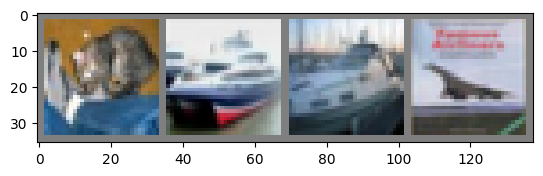

GroundTruth:   cat  ship  ship plane
Predicted:   frog truck truck truck


/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Accuracy of the network on the test images: 20 %


/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Accuracy of plane : 20 %
Accuracy of   car : 37 %
Accuracy of  bird :  3 %
Accuracy of   cat :  0 %
Accuracy of  deer : 12 %
Accuracy of   dog : 47 %
Accuracy of  frog : 18 %
Accuracy of horse : 29 %
Accuracy of  ship :  9 %
Accuracy of truck : 30 %


In [53]:
import torch
import torchvision
import matplotlib.pyplot as plt

def imshow(img):
    """Function to show an image."""
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def print_images_classes(images, labels, classes, prefix="GroundTruth:"):
    """Print the classes of the first few images."""
    imshow(torchvision.utils.make_grid(images))
    print(prefix, ' '.join('%5s' % classes[labels[j]] for j in range(min(4, len(labels)))))

def evaluate_model(net, testloader, device):
    """Evaluate the model on the test dataset."""
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct, total

def class_accuracy(net, testloader, classes, device):
    """Calculate and print the accuracy for each class."""
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    for i in range(len(classes)):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

# Set device
device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")
print(device)
net = net.to(device)
net.eval()  

# Example usage with your testloader and classes
testdataiter = iter(testloader)
images, labels = next(testdataiter)
images, labels = images.to(device), labels.to(device)

print_images_classes(images.cpu(), labels.cpu(), classes)

outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(min(4, len(predicted)))))

correct, total = evaluate_model(net, testloader, device)
print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

class_accuracy(net, testloader, classes, device)

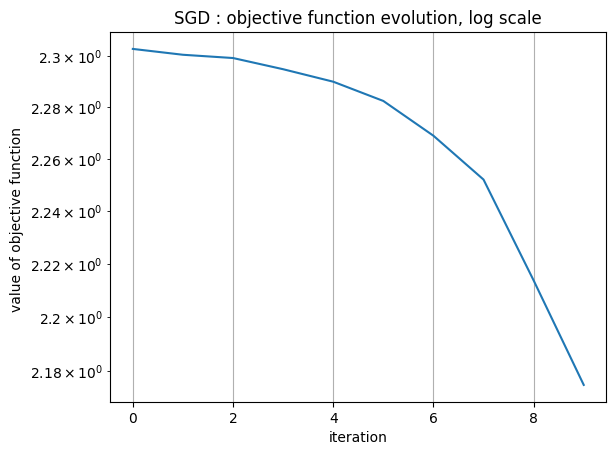

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


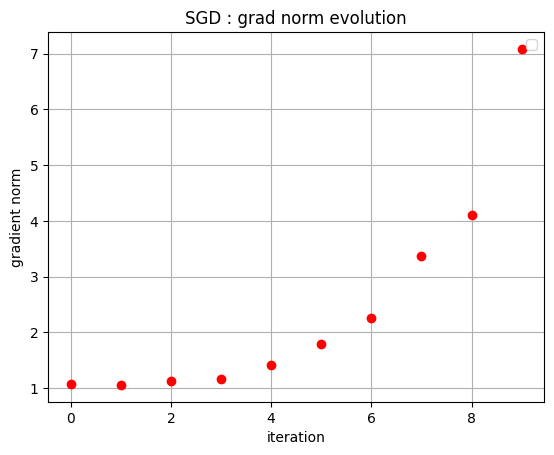

In [54]:
epoch_abs = [i for i in range(n_epoch)]
plt.plot(epoch_abs, full_loss_epoch)
plt.xlabel('iteration')
plt.ylabel('value of objective function ')
plt.title('SGD : objective function evolution, log scale')
plt.yscale('log')
plt.grid()
plt.show()

plt.plot(epoch_abs, grad_norm_epoch, 'ro')
plt.xlabel('iteration')
plt.ylabel('gradient norm')
plt.title('SGD : grad norm evolution')
plt.grid()
plt.legend(loc=1)
plt.show()